# Task 2: Graphs in 3D
## 2.2 Point clouds

#### 2.2.0 Install and import libraries

In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

#### 2.2.1 Point cloud format

In [ ]:
from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T

train_dataset = ModelNet(
    root="ModelNet10",
    train=True,
    pre_transform=T.NormalizeScale()
)

test_dataset = ModelNet(
    root="ModelNet10",
    train=False,
    pre_transform=T.NormalizeScale()
)

Extracting ModelNet10/ModelNet10.zip
Processing...
Done!


In [ ]:
num_points = 1024
transform = T.SamplePoints(num_points)
train_dataset_point_cloud = [transform(data).to("cuda") for data in train_dataset]
test_dataset_point_cloud = [transform(data).to("cuda") for data in test_dataset]

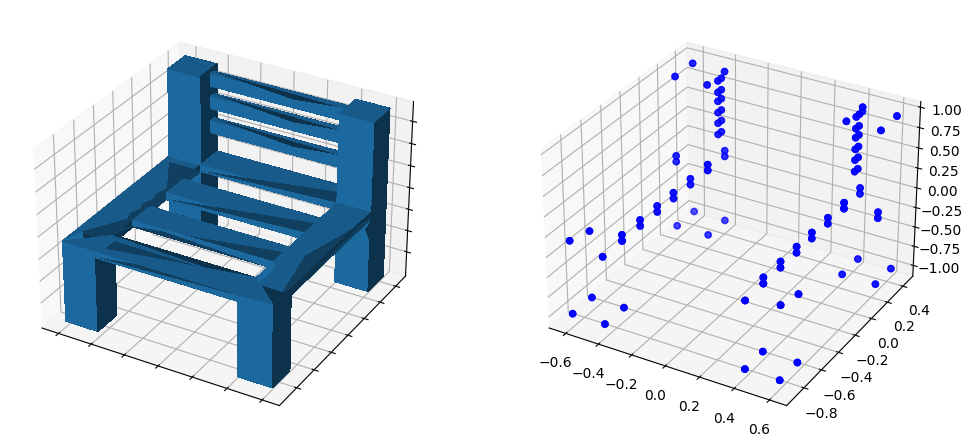

In [ ]:
def visualize(pos, face):
    fig = plt.figure(figsize=(12,18))

    ax = fig.add_subplot(121, projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c='b', marker='o')
    plt.savefig("mesh_pc_chair.eps", dpi = 300, bbox_inches='tight')

visualize_idx = 716
data = train_dataset[visualize_idx]
visualize(data.pos, data.face)

#### 2.2.2 Coordinate baseline

In [ ]:
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool

class CoordinateBaseline(torch.nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(CoordinateBaseline, self).__init__()
        self.conv1 = pyg_nn.GCNConv(3, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, pos, batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        x = self.conv1(pos, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        pooled = global_max_pool(x, batch)
        return self.classifier(pooled)

    @torch.no_grad()
    def eval_accuracy(self, evalloader):
        correct = 0
        total = 0
        for idx, eval_data in enumerate(evalloader):
            pred = self(eval_data.pos, eval_data.batch).max(dim=1)[1]
            correct += pred.eq(eval_data.y).sum().item()
            total += eval_data.y.shape[0]
        return correct / total

def use_gnn(seed, hidden_dim):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = CoordinateBaseline(hidden_dim=hidden_dim, num_classes=train_dataset.num_classes).to("cuda")
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.005, weight_decay=0)

    # data
    train_loader_point_cloud = DataLoader(train_dataset_point_cloud, batch_size=64, shuffle=True)
    test_loader_point_cloud = DataLoader(test_dataset_point_cloud, batch_size=64, shuffle=False)

    # train
    best_test_acc = 0
    for epoch in range(50):
        gnn_model.train()

        for idx, train_data in enumerate(train_loader_point_cloud):
            optimizer.zero_grad()
            pred = gnn_model(train_data.pos, train_data.batch)
            loss = F.cross_entropy(pred, train_data.y)
            loss.backward()
            optimizer.step()

        # valid
        if (epoch + 1) % 1 == 0:
            gnn_model.eval()
            valid_acc = gnn_model.eval_accuracy(test_loader_point_cloud)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, valid_acc))

            if valid_acc > best_test_acc:
                best_test_acc = valid_acc

    # test
    return best_test_acc

seed = 42
test_acc = use_gnn(seed=seed, hidden_dim=32)
print("Test accuracy: {}\n".format(test_acc))

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:18: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 1	Validation accuracy: 0.39537444933920707
Epoch: 2	Validation accuracy: 0.6574889867841409
Epoch: 3	Validation accuracy: 0.7301762114537445
Epoch: 4	Validation accuracy: 0.75
Epoch: 5	Validation accuracy: 0.7588105726872246
Epoch: 6	Validation accuracy: 0.763215859030837
Epoch: 7	Validation accuracy: 0.775330396475771
Epoch: 8	Validation accuracy: 0.776431718061674
Epoch: 9	Validation accuracy: 0.8083700440528634
Epoch: 10	Validation accuracy: 0.7973568281938326
Epoch: 11	Validation accuracy: 0.801762114537445
Epoch: 12	Validation accuracy: 0.8204845814977973
Epoch: 13	Validation accuracy: 0.7951541850220264
Epoch: 14	Validation accuracy: 0.8270925110132159
Epoch: 15	Validation accuracy: 0.8215859030837004
Epoch: 16	Validation accuracy: 0.8127753303964758
Epoch: 17	Validation accuracy: 0.788546255506608
Epoch: 18	Validation accuracy: 0.7797356828193832
Epoch: 19	Validation accuracy: 0.8414096916299559
Epoch: 20	Validation accuracy: 0.8281938325991189
Epoch: 21	Validation accura

#### 2.2.3 PointNet    
https://github.com/fxia22/pointnet.pytorch/tree/master

In [ ]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size()[0]
        # x = F.relu(self.bn1(self.conv1(x)))
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        # x = F.relu(self.bn4(self.fc1(x)))
        # x = F.relu(self.bn5(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        iden = torch.tensor([[1,0,0,0,1,0,0,0,1]], dtype=torch.float32).repeat(batchsize, 1).to("cuda")
        x = x + iden
        x = x.view(-1, 3, 3)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform=False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        # if self.feature_transform:
        #     self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        # x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.bn3(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k, num_points, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.num_points = num_points

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        # x = F.relu(self.bn1(self.fc1(x)))
        # x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = F.relu(self.fc1(x))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        # return F.log_softmax(x, dim=1), trans, trans_feat
        return F.log_softmax(x, dim=1)

    @torch.no_grad()
    def eval_accuracy(self, evalloader):
        correct = 0
        total = 0
        for idx, eval_data in enumerate(evalloader):
            pred = self(eval_data.pos.reshape(-1,self.num_points,3).transpose(1,2)).max(dim=1)[1]
            correct += pred.eq(eval_data.y).sum().item()
            total += eval_data.y.shape[0]
        return correct / total

In [ ]:
num_points_list = [512, 1024, 2048]

train_dataset_point_cloud_list = []
test_dataset_point_cloud_list = []

for num_points in num_points_list:
    transform = T.SamplePoints(num_points)
    train_dataset_point_cloud_list.append([transform(data).to("cuda") for data in train_dataset])
    test_dataset_point_cloud_list.append([transform(data).to("cuda") for data in test_dataset])

In [ ]:
def use_pointnet(seed, num_points, train_set, test_set):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    pointnet_model = PointNetCls(k=train_dataset.num_classes, num_points=num_points).to("cuda")
    optimizer = torch.optim.Adam(pointnet_model.parameters(), lr=0.001, weight_decay=5e-4)

    # data
    train_loader_point_cloud = DataLoader(train_set, batch_size=64, shuffle=True)
    test_loader_point_cloud = DataLoader(test_set, batch_size=64, shuffle=False)

    # train
    best_test_acc = 0
    for epoch in range(30):
        pointnet_model.train()

        for idx, train_data in enumerate(train_loader_point_cloud):
            optimizer.zero_grad()
            pred = pointnet_model(train_data.pos.reshape(-1,num_points,3).transpose(1,2))
            loss = F.nll_loss(pred, train_data.y)
            loss.backward()
            optimizer.step()

        # valid
        if (epoch + 1) % 1 == 0:
            pointnet_model.eval()
            valid_acc = pointnet_model.eval_accuracy(test_loader_point_cloud)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, valid_acc))

            if valid_acc > best_test_acc:
                best_test_acc = valid_acc

    # test
    return best_test_acc

seed = 42
accuracis = []
for i in range(len(num_points_list)):
    print("### Sampling size: {}".format(num_points_list[i]))
    test_acc = use_pointnet(seed=seed,
                            num_points=num_points_list[i],
                            train_set=train_dataset_point_cloud_list[i],
                            test_set=test_dataset_point_cloud_list[i])
    accuracies.append(test_acc)
    print("Test accuracy: {}\n".format(test_acc))

### Sampling size: 512
Epoch: 1	Validation accuracy: 0.5374449339207048
Epoch: 2	Validation accuracy: 0.7279735682819384
Epoch: 3	Validation accuracy: 0.788546255506608
Epoch: 4	Validation accuracy: 0.7742290748898678
Epoch: 5	Validation accuracy: 0.8270925110132159
Epoch: 6	Validation accuracy: 0.8447136563876652
Epoch: 7	Validation accuracy: 0.7918502202643172
Epoch: 8	Validation accuracy: 0.8193832599118943
Epoch: 9	Validation accuracy: 0.8226872246696035
Epoch: 10	Validation accuracy: 0.8436123348017621
Epoch: 11	Validation accuracy: 0.8436123348017621
Epoch: 12	Validation accuracy: 0.8226872246696035
Epoch: 13	Validation accuracy: 0.816079295154185
Epoch: 14	Validation accuracy: 0.8788546255506607
Epoch: 15	Validation accuracy: 0.8601321585903083
Epoch: 16	Validation accuracy: 0.8733480176211453
Epoch: 17	Validation accuracy: 0.8667400881057269
Epoch: 18	Validation accuracy: 0.8601321585903083
Epoch: 19	Validation accuracy: 0.8237885462555066
Epoch: 20	Validation accuracy: 0.84471